In [4]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

# **AA_utils**

In [5]:
def graficar_curva_elbow(X, N, GMM=False):
    plt.figure()
    Nc = range(1, N+1)
    if (GMM):
        kmeans = [GaussianMixture(n_components=i) for i in Nc]
    else:
        kmeans = [KMeans(n_clusters=i) for i in Nc]

    # score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    if (GMM):
        score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
        scoreBIC = [kmeans[i].fit(X).bic(X) for i in range(len(kmeans))]
    else:
        score = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]

    plt.plot(Nc, score, 'b')
    plt.xlabel('Number of Clusters')
    plt.title('Elbow Curve')
    plt.grid()
    if (GMM):
        plt.ylabel('log(verosimilitud)')
        plt.figure()
        plt.plot(Nc, scoreBIC, 'r--')
        plt.title('BIC Curve')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Bayesian information criterion')
        plt.grid()
    else:
        plt.ylabel('Promedio de sumas de distancias')
    plt.show()


# índice Silhouette
def graficar_indice_silhouette(X, N, GMM=False):

    plt.figure()
    Nc = range(2, N+1)
    if (GMM):
        # kmeans = [GaussianMixture(n_components=i) for i in Nc]
        print("Sin terminar silhouette para GMM")
    else:
        kmeans = [KMeans(n_clusters=i) for i in Nc]

    # score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    score = [silhouette_score(X, kmeans[i].fit(X).predict(X))
             for i in range(len(kmeans))]
    score
    plt.plot(Nc, score)
    plt.xlabel('Número de Clusters')
    plt.ylabel('Promedio de índice silhouette')
    plt.title('Índice silhouette para distintos K')
    plt.grid()
    plt.show()


def graficar_indice_silhouette_k(X, n_clusters):

    # Compute the silhouette scores for each sample
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    plt.figure()
    ax1 = plt.gca()
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot para cada Cluster.")
    ax1.set_xlabel("Coeficientes silhouette")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()


def graficar_GMM(data, modelo, labels=False, probs=False):
    # display predicted scores by the model as a contour plot
    cant_points = 200
    x = np.linspace(min(data[:, 0])*0.9, max(data[:, 0])*1.1, cant_points)
    y = np.linspace(min(data[:, 1])*0.9, max(data[:, 1])*1.1, cant_points)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    if (probs):
        Z = np.exp(modelo.score_samples(XX))
    else:
        Z = -modelo.score_samples(XX)
    Z = Z.reshape(X.shape)

    centros = modelo.means_
    cant_gauss = centros.shape[0]
    if (probs):
        CS = plt.contour(X, Y, Z, levels=np.linspace(
            0, np.max(Z), cant_gauss*10),  linewidths=2)
        plt.title('Probabilidades de la GMM')
    else:
        CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                         levels=np.logspace(0, 3, 20),  linewidths=2)
        plt.title('Negative log-likelihood de la GMM')
    plt.colorbar(CS, shrink=0.5)
    if (labels):
        etiq = modelo.predict(data)
        plt.scatter(data[:, 0], data[:, 1], s=30, c=etiq)
    else:
        plt.scatter(data[:, 0], data[:, 1], s=30)
    plt.scatter(centros[:, 0], centros[:, 1],
                marker='o', c='red', s=100, alpha=0.8)
    plt.grid()
    plt.axis('tight')
    plt.show()


def visualizar_clustering_2D(data, labels, centers):
    values = data.to_numpy()
    plt.figure()
    plt.scatter(values[:, 0], values[:, 1], c=labels, s=50, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1],
                marker='*', c='red', s=600, alpha=0.8)
    plt.show()


def graficar_DBSCAN_2D(data, labels, db, EPS, MINSAM, n_clusters_):
    plt.figure()
    noise_maks = labels == -1
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    # plot RUIDO
    x = data[noise_maks]  # datos RUIDO (outliers)
    plt.scatter(x[:, 0], x[:, 1], color=[0.2, 0.2, 0.2, 0.8],
                s=20, cmap='viridis', label='ruido', marker='x')
    # plot datos CORE en clusters
    x = data[~noise_maks & core_samples_mask]
    plt.scatter(x[:, 0], x[:, 1], c=labels[~noise_maks &
                core_samples_mask], s=30, cmap='viridis', label='Cores')
    # plot datos NO CORE en clusters
    x = data[~noise_maks & ~core_samples_mask]
    plt.scatter(x[:, 0], x[:, 1], c=labels[~noise_maks & ~core_samples_mask],
                s=20, cmap='viridis', label='Borders', marker='D')

    title = "eps= {}, min_samples= {}, #clusters= {}".format(
        EPS, MINSAM, n_clusters_)
    plt.title(title)
    plt.legend()
    plt.show()

# **Gaussian Models**

*   Un modo más “Soft” podría ser modelando cada cluster como una gaussiana.
*   Ahora cada patrón no está dentro o fuera del cluster, sino que pertenece
con cierta probabilidad.
*   La media de la distribución podría considerarse el centro del cluster.a
*   Se agrega la matriz de covarianza.

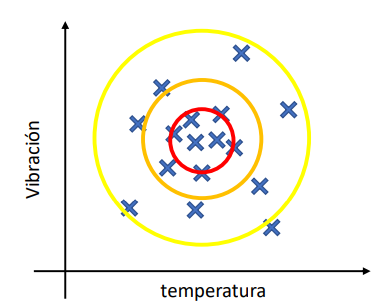

# **Simple blobs 2**

**Carga del dataset**

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/KevinFDI/IML_Practica_4/main/datasets/simple_blobs_2.csv") 

**Normalizo**

In [7]:
NORMALIZAR = 1
if (NORMALIZAR):
    scaler_GMM = StandardScaler()
    scaler_GMM.fit(df)
    df = scaler_GMM.transform(df)

In [8]:
plt.close('all')

In [9]:
data = pd.DataFrame(df).values

**Curvas**

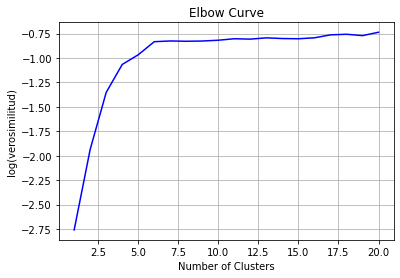

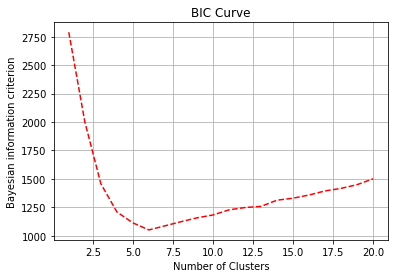

In [10]:
graficar_curva_elbow(data, 20, GMM = 1)

**Bayesian information criterion** (BIC) es un criterio para selección de modelos.

**Cuanto más chico mejor. OBSERVACIÓN: En este caso el valor óptimo de k se encuentra entre 3 y 6 (escojo 3)**

𝐵𝐼𝐶 = 𝑘 𝑙𝑜𝑔 𝑛 − 2 𝑙𝑜𝑔 ℒ

ℒ= Verosimilitud, n= # datos, k= parámetros a estimar en el modelo

**Fit a Gaussian Mixture Model**

In [11]:
k_optimo = 3
modelo = GaussianMixture(n_components = k_optimo, verbose = True, covariance_type = 'full')
modelo.fit(data)
print('Score del modelo: ', round(modelo.score(data),2))

Initialization 0
Initialization converged: True
Score del modelo:  -1.35


**Graficar GMM (2D)**

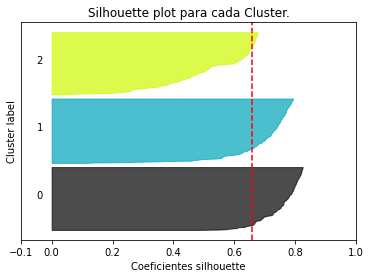

In [12]:
graficar_indice_silhouette_k(data, k_optimo)

El valor de s(x) varía entre -1 y 1:


*   1 = Buen agrupamiento
*   0 = Indiferente
*   -1 = Mal agrupamiento

**OBSERVACIÓN: Es un buen agrupamiento por estar cercano a 1**

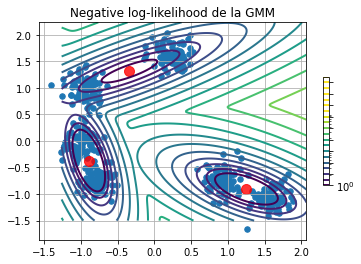

In [13]:
graficar_GMM(data, modelo, probs = False, labels = False)

Para **detectar anomalías** se utiliza el siguiente gráfico

Establezo una línea de corte (umbral) para decir que un dato es
anómalo: en este caso, como es arbitrario, la coloco en: 𝝁 − 2𝝈

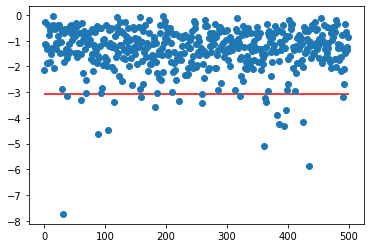

In [14]:
scores= modelo.score_samples(data)
plt.plot(scores, 'o')

u_scores= np.mean(scores)
s_scores= np.std(scores)
linea_de_corte= u_scores - 2*s_scores
plt.hlines(linea_de_corte, 0, data.shape[0], color='r')
anomalos= data[scores< linea_de_corte]

Datos anómalos
[[ 1.26332107 -1.66803522]
 [ 1.81677706 -0.61676618]
 [ 1.11917775 -0.194091  ]]


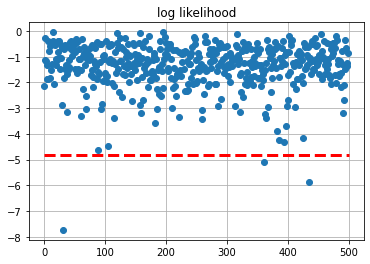

In [15]:
#  Otra alternativa es la siguiente para detectar anómalos
u_scores = np.mean(scores)
s_scores = np.std(scores)
linea_de_corte = u_scores - 4*s_scores
anomalos_ind = scores < linea_de_corte
anomalos = data[anomalos_ind]
print('Datos anómalos'), print(anomalos)

plt.figure()
plt.title('log likelihood')
plt.plot(scores, 'o')
plt.hlines(linea_de_corte, 0, data.shape[0],
           color='r', linestyle='--', linewidth=3)
plt.grid()
plt.show()